In [1608]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [1609]:
## 读取、加载数据
# 分别加载训练集和测试集
train_data = pd.read_excel("番剧数据-模型训练数据【2015-2023】.xlsx")
test_data = pd.read_excel("番剧数据-模型测试数据【2015-2023】.xlsx")
# 检查训练集和测试集的数据情况
print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
# 删除第一列的id列，然后将所有数据集拼接到一个变量里
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(799, 8)
(654, 7)
    id  popularity    likes    coins  bullets      chases      volume
0  694         9.8  3327536  1427005  1316574  45520000.0  2226750.95
1  176         9.4   640356   763230  1482117  46650000.0  1900265.95
2    8         9.9  1973797  1158512  1109662  50230000.0  1835502.84
3  183         9.7   825660   605927  1443779  46390000.0  1696129.37
   popularity    likes    coins  reposts  reposts  bullets      chases
0         9.8  3327536  1427005   168897   168897  1316574  45520000.0
1         9.4   640356   763230    98163    98163  1482117  46650000.0
2         9.9  1973797  1158512   271096   271096  1109662  50230000.0
3         9.7   825660   605927   107139   107139  1443779  46390000.0


In [1610]:
## 数据预处理
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   popularity      likes     coins   reposts   reposts   bullets    chases
0    0.778651  10.615742  8.450107  5.189164  5.189164  2.553222  3.133537
1    0.457794   1.660560  4.316963  2.816677  2.816677  2.930000  3.232916
2    0.858865   6.104329  6.778275  8.617017  8.617017  2.082287  3.547762
3    0.698437   2.278096  3.337480  3.117741  3.117741  2.842742  3.210050


In [1611]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# 在本案例中，由于已对爬取数据进行了数据清洗和预处理，因而没有增加额外的特征值
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(1453, 6)

In [1612]:
# 再次检查all_features中是否存在NAN数据，将其记为0
# 在本案例中，已无NAN数据
non_numeric_columns = all_features.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)
 
for column in non_numeric_columns:
    all_features[column] = all_features[column].astype(float)
    
all_features = all_features.fillna(0)

Index([], dtype='object')


In [1613]:
# 转化为张量，用于训练
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.volume.values.reshape(-1, 1), dtype=torch.float32)

In [1614]:
# 定义一个带有平方损失的线性模型
# in_features表示输入值，其个数（大小）和特征值的数目相同，也就是train_features的第一维
# 定义全连接层Linear层，输入为in_features，输出为一个数
loss = nn.MSELoss()

# 添加多项式特征
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1, include_bias=False)
all_features_poly = poly.fit_transform(all_features)

# 转换为张量
n_train = train_data.shape[0]
train_features = torch.tensor(all_features_poly[:n_train], dtype=torch.float32)
test_features = torch.tensor(all_features_poly[n_train:], dtype=torch.float32)
train_labels = torch.tensor(train_data.volume.values, dtype=torch.float32).view(-1, 1)
in_features = train_features.shape[1]

# 修改模型为多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )
    return net

# def get_net():
#     net = nn.Sequential(nn.Linear(in_features,1))
#     return net

In [1615]:
# log_rmse()函数对神经网络做出一个对数相对误差计算，返回一个误差值，该误差为相对误差
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [1616]:
# 借助Adam算法训练模型参数
# train_ls、test_ls两个数组用来存储训练损失和测试损失
# 使用torch里的函数创建好迭代器访问训练数据集的特征与标签
# 执行迭代，每次迭代先清除上一次迭代的梯度，使用net(X)获取预测结果，然后用loss()计算损失l，用l进行反向传播，更新梯度与模型参数
# 在每次迭代结束后，用对数损失计算函数计算训练集和测试集上的对数误差，然后将误差结果添加到数组里
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [1617]:
# 利用K则交叉验证来评估模型的性能
# 通过K则交叉验证在不同折上的不同表现，以及比较模型对训练集和测试集上的误差，可以确定模型遇到的一些问题，确定其是否遇到欠拟合或过拟合
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [1618]:
# 当我们在k折交叉验证中训练k次后，返回训练和验证误差的平均值。
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.981312, 验证log rmse0.572826
折2，训练log rmse1.008584, 验证log rmse0.558000
折3，训练log rmse1.190868, 验证log rmse0.791582
折4，训练log rmse0.572098, 验证log rmse2.460178
4-折验证: 平均训练log rmse: 0.938216, 平均验证log rmse: 1.095646


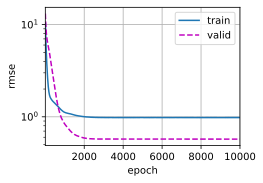

In [1619]:
# 运行K折验证
k, num_epochs, lr, weight_decay, batch_size = 4, 10000, 0.001, 0, 100
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

In [1620]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['volume'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['id'], test_data['volume']], axis=1)
    submission.to_csv('result', index=False)

训练log rmse：0.885718


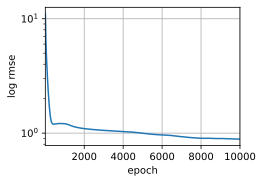

In [1621]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)